>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br>
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Writing_Ranking_Performance_Metrics_to_WhyLabs)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Writing_Ranking_Performance_Metrics_to_WhyLabs) to leverage the power of whylogs and WhyLabs together!*

# Monitoring Ranking Model Performance Metrics

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/experimental/Writing_Ranking_Performance_Metrics_to_WhyLabs.ipynb)

In this tutorial, we'll show how you can log ranking metrics of your ML Model with whylogs, and how to send it to your dashboard at Whylabs Platform. whylogs tracks the following [ranking metrics](https://towardsdatascience.com/comprehensive-guide-to-ranking-evaluation-metrics-7d10382c1025):
*   precision@k
*   recall@k
*   average precision@k (AP@k)
*   mean reciprocal rank (MRR)
*   normalized discounted cumulative gain@k (NDCG@k)

This example is split into two parts:

- **Part 1 - End-to-end Example**: A simple example of logging ranking metrics with whylogs and sending the results to the WhyLabs platform.
- **Part 2 - API Usage** : More detailed examples on API use - expected parameters and supported data types.


## Part 1: End-to-end Example

### Installing whylogs

First, let's install whylogs.

In [ ]:
%pip install 'whylogs>=1.3.27'

In [2]:
import pandas as pd

## Example data

whylogs supports different data types for ranking metrics, but let's stick with the simplest example for now.

Consider we have the following documents:

$D_{1}, D_{2}, D_{3}$

And we know the ground truth of whether or not each document is relevant to a search query:

$Rel_{D_{1}}=True$

$Rel_{D_{2}}=False$

$Rel_{D_{3}}=True$

Which means that $D_{1}$ and $D_{3}$ are relevant to the search query, and $D_{2}$ is not.


Let's say, now, that for a given query, our system recommended the following documents in the following order:

$Rank_{D_1}= 2$

$Rank_{D_2}= 3$

$Rank_{D_3}= 1$

Which means that $D_{3}$ was recommended first, $D_{1}$ was recommended second, and $D_{2}$ was recommended third.

We can translate this by using a `prediction_column` and a `target_column` in the following way:


In [3]:
df = pd.DataFrame({"targets": [[1, 0, 1]], "predictions": [[2,3,1]]})

`predictions` contains the rank of each recommended document, while `targets` encodes the binary relevance of each document.

We can proceed to log these metrics with whylogs:

In [5]:
# Log ranking metrics
from whylogs.experimental.api.logger import log_batch_ranking_metrics

results = log_batch_ranking_metrics(
    data=df,
    prediction_column="predictions",
    target_column="targets",
    k=3,
    log_full_data=True,
)

# NOTE: If you've already ran why.log() on your input data, change log_full_data to False.

Let's check the results. Let's take a look at the mean and count for each ranking performance metric calculated:

In [4]:
results.view().to_pandas()[['counts/n','distribution/mean']]

,counts/n,distribution/mean
column,,
accuracy_k_3,1,1.000000
average_precision_k_3,1,1.000000
norm_dis_cumul_gain_k_3,1,1.000000
precision_k_3,1,0.666667
predictions,1,0.000000
recall_k_3,1,1.000000
reciprocal_rank,1,1.000000
targets,1,0.000000
top_rank,1,1.000000


Each row in a dataframe corresponds to a single query. Since we only have one query, `counts/n` is 1 and, then, the mean corresponds to the calculated metric value for this query.

The `k_3` suffix in the metric names indicates that the metric was calculated for the top 3 documents. If `k` is not passed, it is defined automatically  according to the length of `predictions` column.

### Send profile summaries to WhyLabs platform
Required information can be found at https://hub.whylabsapp.com under the Settings > Model and Dataset Management page.

API keys are only shown once, so you may need to create a new one and save somewhere safe.

In [ ]:
# Configure WhyLabs info, if needed
import getpass
import os

os.environ["WHYLABS_DEFAULT_ORG_ID"] = input("Enter your WhyLabs Org ID")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input("Enter your WhyLabs Dataset ID")
os.environ["WHYLABS_API_KEY"] =  getpass.getpass("Enter your WhyLabs API key")
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Using API Key ID:  


In [ ]:
# Write the results to WhyLabs platform
results.writer("whylabs").write()

The ranking metrics should be available in the WhyLabs platform, under the Performance tab.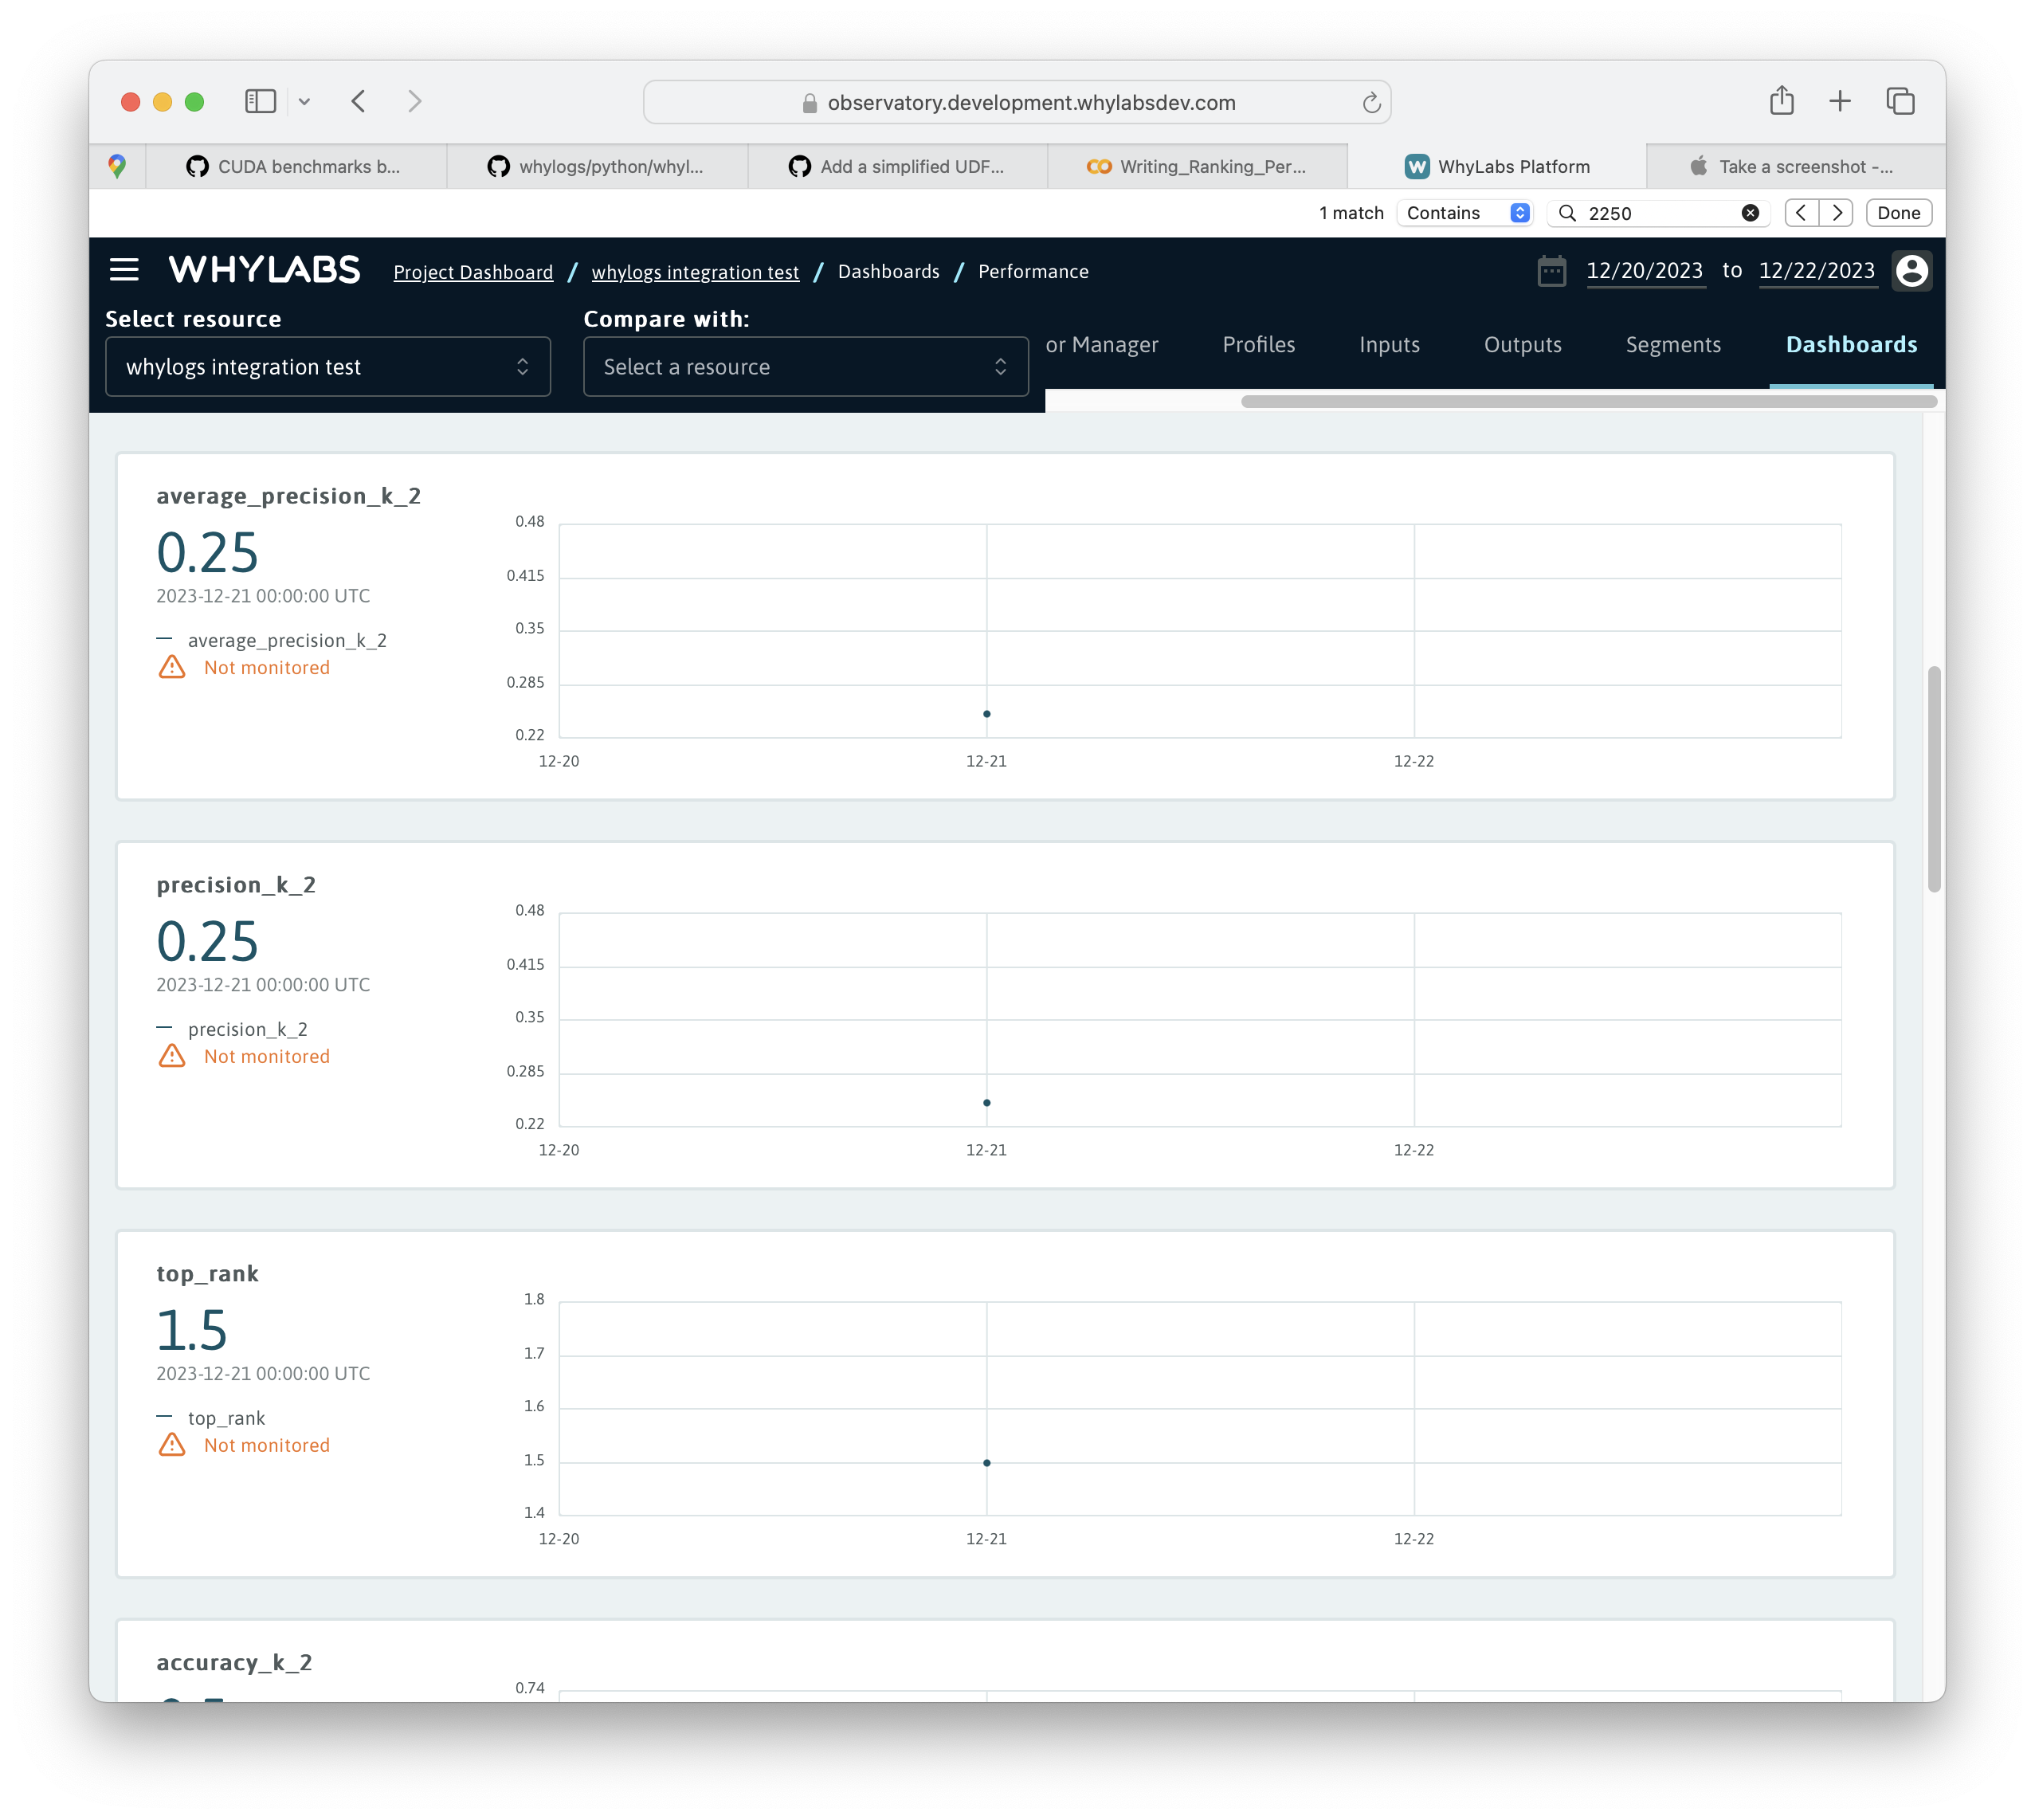

## Part 2 - API Usage

whylogs supports different data types and different semantics for each data type. Let's cover them in the following sections:

1. Non-numeric Data
    - Binary Relevance
2. Numeric Data
    - Binary Relevance
    - Multi-class Relevance

> It's noteworthy that this API is for batch metrics -- meaning that the metrics are not meant to be merged 
>together. This means that multiple profiles from distributed machines, Spark, or multiple uploads within the 
>model granularity window are discouraged.
>Contrastingly, non-batch metrics APIs can be merged (but one is not yet released for ranking metrics).


### 1. Non-numeric Data

You can pass a list of strings for each row in both target and prediction columns, like this:

In [6]:
non_numerical_df = pd.DataFrame(
    {
        "raw_predictions": [
            ["cat", "pig", "elephant"],
            ["horse", "donkey", "robin"],
            ["cow", "pig", "giraffe"],
            ["pig", "dolphin", "elephant"],
        ],
        "raw_targets": [
            ["cat", "elephant"],
            ["dog"],
            ["pig", "cow"],
            ["cat", "dolphin"],
        ],
    }
)

# 1st query: 
# Recommended items: [cat, pig, elephant]
# Relevant items: [cat, elephant]

# So, the first and third recommendations are relevant, second is not.

# 2nd query:
# Recommended items: [horse, donkey, robin]
# Relevant items: [dog]

# None of the recommended items were relevant.

Note that this is a case of binary relevance, since we don't have a notion of varying degrees of relevance.

Also note that, in this case, the lists for targets and predictions can have different lengths.

Then, we can log our performance ranking metrics as usual. We just need to be sure to set `convert_non_numeric` to __True__:


In [7]:
results = log_batch_ranking_metrics(
    k=2,
    data=non_numerical_df,
    prediction_column="raw_predictions",
    target_column="raw_targets",
    convert_non_numeric=True
)

In this case, we are passing `k=2`, so the performance metrics will take into account only the top 2 recommended items.

### 2. Numeric Data

There are a number of possible ways to pass numeric data into ranking performance metrics.

Let's first talk about the binary relevance case: where documents' relevances are encode to either relevant or non-relevant.

#### Binary Relevance: Single target column

One way is to pass a single column to `log_batch_ranking_metrics` as the target column, like this:


In [6]:
binary_single_df = pd.DataFrame(
    {
        "ranked_targets": [
            [True, False, True], # First recommended item: Relevant, Second: Not relevant, Third: Relevant
            [False, False, False], # None of the recommended items are relevant
            [True, True, False], # First and second recommended items are relevant
            [False, True, False], # Second recommended item is relevant
        ]
    }
)

result = log_batch_ranking_metrics(data=binary_single_df, target_column="ranked_targets", k=3)

In this case, we are passing the recommended items directly with their respective relevance in a single column, avoiding the need to pass two separate `prediction` and `target` columns. In this case, we assume that the target column is sorted by rank, from most recommended to least recommended.

#### Binary Relevance: Separate target and prediction columns

Here is how the same data could be passed if using separate `target` and `prediction` columns:

In [9]:
binary_df = pd.DataFrame(
    {
        "raw_predictions": [
            [1, 2, 3], # Item no. 1 is the most recommended, then item no. 2, then item no. 3
            [1, 2, 3], # same
            [1, 2, 3], 
            [1, 2, 3], 
        ],
        "raw_targets": [
            [True, False, True], # Items No. 1, 2, and 3 are: Relevant, Not relevant, Relevant
            [False, False, False], # No relevant items
            [True, True, False], # Items No. 1, 2, and 3 are: Relevant, Relevant, Not relevant
            [False, True, False], # Items No. 1, 2, and 3 are: Not relevant, Relevant, Not relevant
        ]
    }
)

result = log_batch_ranking_metrics(
    data=binary_df,
    prediction_column="raw_predictions",
    target_column="raw_targets",
    k=3,
)

The predictions contain the ranks of each document, and targets contain the relevance of each document.

#### Binary Relevance: Separate target and score columns

Instead of the predicition column, you can also pass a list of scores through `score_column`.

The following is equivalent to the previous two binary examples we just saw:


In [5]:
binary_with_score_df = pd.DataFrame(
    {
        "raw_scores": [
            [70, 0.4, 0.1], # Item no. 1 is the most recommended, then item no. 2, then item no. 3
            [1.0, 0.6, 0.3], # same
            [1.4, 0.78, 0.54], 
            [42, 7, 5], 
        ],
        "raw_targets": [
            [True, False, True], # Items No. 1, 2, and 3 are: Relevant, Not relevant, Relevant
            [False, False, False], # No relevant items
            [True, True, False], # Items No. 1, 2, and 3 are: Relevant, Relevant, Not relevant
            [False, True, False], # Items No. 1, 2, and 3 are: Not relevant, Relevant, Not relevant
        ]
    }
)

result = log_batch_ranking_metrics(
    data=binary_with_score_df,
    score_column="raw_scores",
    target_column="raw_targets",
    k=3,
)

The score column is used to sort the recommended items, where the highest core would be the first recommended item. Since, in this case, all of the queries are monotonically decreasing, it's equivalent to prediction being `[1,2,3]`

### Multi-class Relevance

You can also have non-binary degrees of relevance being passed to your target column, like this:


In [11]:
# single target column
df_multi_single_column = pd.DataFrame({"ranked_targets": [[3, 2, 3, 0, 1, 2, 3, 2]]})

# target + prediction columns

df_multi = pd.DataFrame({"predictions": [[5, 4, 2, 1, 7, 8, 6, 3]],
                         "targets": [[1, 0, 2, 3, 3, 2, 2, 3]],})

# target + score columns

df_multi_score = pd.DataFrame({"scores": [[0.05, 1.1, 1.0, 0.5, 0.0]],
                               "targets": [[10, 0, 0, 1, 5]]})


The parameters for calling `log_batch_ranking_metrics` match the binary cases shown before, so we will omit those for this case.

Note that some metrics are only meaningul for binary relevance metrics, like __Average Precision__.